# Thomas Fire Analysis
#### Author: Anna Ramji ([@a-ramji](https://github.com/a-ramji), a-ramji@github.io)
- This notebook is part of my Thomas Fire analysis [github repository](https://github.com/a-ramji/thomas-fire)


# About

### Purpose


There are two primary goals of this data analysis and visualization. 
1. Use county-level AQI data to show the **air quality in Santa Barbara County from 2017-2018, highlighting the Thomas Fire**, which occurred in December, 2017.
2. Use Landsat and a shapefile of fire perimeters in California to **create a false color image displaying the fire scar from the 2017 Thomas Fire**

### Highlights of analysis
- Fetch vector data from an online repository (AQI data)

- Clean & update AQI data

- Time series analysis & visualization
- Read in `xarray.Dataset` for raster data
- Read in pre-processed shapefile
- Clean & update raster data
- Clean & update shapefile data, extract polygon(s) of interest
- Create False Image visualization of raster data
- Visualize raster data with added fire border shapefile layer
    
    
### Dataset description

#### AQI Data
- The AQI data I'll be using in my analysis is [Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) data from the [US Environmental Protection Agency](https://www.epa.gov) to visualize the impact on the AQI of the 2017 [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire) in Santa Barbara County. 
- More specifically, I'll be importing county-level AQI data for 2017 and 2018

#### Landsat Collection 2 Level-2 data from Landsat 8 
- The second is a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite
- This data that was accessed and pre-processed in Microsoft's Planetary Computer to remove data outside land and coarsen the spatial resolution ([Landsat Collection in MPC](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)) by Professor Carmen Galaz-García ([@carmengg](https://github.com/carmengg) on GitHub)

**Information about Landsat bands from USGS:**

- [What are the band designations for the Landsat satellites?](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)

- [Common Landsat Band Combinations](https://www.usgs.gov/media/images/common-landsat-band-combinations)

- [How do I use a scale factor with Landsat Level-2 science products?](https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products)


#### California Shapefile
- The third dataset is A shapefile of fire perimeters in California during 2017. The [complete file can be accessed in the CA state geoportal.](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about)



### References & data sources

- AQI Data: https://aqs.epa.gov/aqsweb/airdata (Accessed October, 2023)
- Landsat Data: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2, pre-processed on Microsoft's Planetary Computer by Dr. Carmen Galaz-García (Accessed November, 2023). This file will by in a data folder in my github repo for this project. 
- CA Shapefile: as mentioned above, the [complete file can be accessed in the CA state geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about). I'll be using a local copy of the shapefile in a hidden data folder in this repo. (Accessed November, 2023)

In [1]:
# before we begin our analysis, let's load in the relevant libraries, packages, and modules:

# importing libraries with standard abbreviations
# basic libraries
import os # like here() in R
import numpy as np
import pandas as pd

# for spatial/raster data etc. 
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd

# for plotting 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends
import matplotlib.lines as mlines # for making our customized marker in the legend
from matplotlib.lines import Line2D  # also for this custom marker 
from matplotlib.markers import MarkerStyle # also for custom markers


from shapely.geometry import Point 
from shapely.geometry import box # for making our bounding box/cropping (optional)

from rasterio.features import rasterize # for rasterizing polygons

pd.set_option('display.max_columns', None) # setting custom full output options for data exploration (optional) 



## Importing Data

In [2]:
#======= AQI Data for 2017-2018 =======#

# reading in data using the download links in EPA's AQS data (cited in the About section)

# reading in 2017 county-level AQI data  
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')

# reading in 2018 county-level AQI data
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')


#=====(pre-processed) Landsat Data =====#

# setting file path for landsat data (NetCDF file),
# using os() for multi-operating system compatibility
landsat_fp = os.path.join(os.getcwd(), 'data', 'landsat8-2018-01-26-sb-simplified.nc')

#  importing the landsat data it with rioxarray
landsat = rioxr.open_rasterio(landsat_fp)


# ======= California Fire Borders ======= #

# setting file path for CA Fire Perimeters data, 
# using os() for multi-operating system compatibility
ca_fp = os.path.join(os.getcwd(), 'data', 'California_Fire_Perimeters_2017', 'California_Fire_Perimeters_2017.shp')

# importing the CA Fire Perimeters 2017 shapefile from our filepath using geopandas
ca_fires = gpd.read_file(ca_fp)

# Santa Barbara County AQI Data 

### Data Cleaning & Updates

In [ ]:
# currently, our 2017 and 2018 data are separate... Let's start by concatenating them:

# concatenating our two years of data into one dataframe
aqi = pd.concat([aqi_17, aqi_18])

# ====== Cleaning column names ====== #

# cleaning up the column names to be lower_snake_case
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')


# ====== Filter to Santa Barbara County ====== #

# selecting rows where county_name is equal to "Santa Barbara"
aqi_sb = aqi[aqi.county_name == "Santa Barbara"]


# ====== Data sub-selection ======= #

# using .loc to select the columns after county_code
aqi_sb = aqi_sb.loc[:,'date':'number_of_sites_reporting']


# ====== Updating datatype of "date" column, set as index ====== #

# using .loc to select the columns after county_code
aqi_sb = aqi_sb.loc[:,'date':'number_of_sites_reporting']

# updating index to the date column
aqi_sb = aqi_sb.set_index('date')

# Setting `date` to be our new index is more intuitive, and will also help
# us plot the AQI over time in our analysis later on

Now that our data is cleaned and updated, we can move on to our analysis and visualization.

## AQI Data Analysis & Visualization 

We could just go straight to plotting our AQI data over time in Santa Barbara County, but it would be interesting to also show a 5-day rolling average plotted on top of it. 

In order to make our data visualization more legible, we can compute a [rolling average](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html) of our AQI over time and add that as a column for our analysis.

- `rolling()` is a method for `pandas.series` that provides rolling window calculations
- the parameter `'5D'` indicates we want the window to be 5 days
- This is a lazy method (think groupby), so we need to specify what we want to calculate over each window
- we'll also use the aggregator function `mean()`
    - this indicates that we want the mean over each window

In [14]:
# computing a 5-day rolling average of AQI 
# and inserting it as a new column at the end of the dataframe
aqi_sb.insert(loc = 5,
             column = "five_day_average",
             value = aqi_sb.aqi.rolling('5D').mean())

Great! Now we can make a line plot showing both the daily AQI and the 5-day average (5-day average on top of the AQI), using `matplotlib`

<AxesSubplot:title={'center':'Daily AQI and 5-day average 2017-2018'}, xlabel='Date', ylabel='AQI (PM 2.5)'>

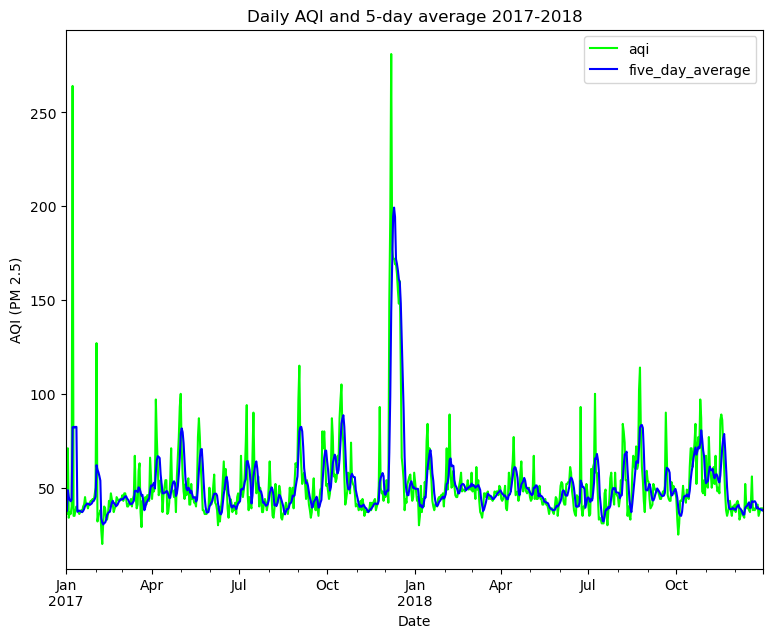

In [16]:
# plotting our daily aqi and five day rolling average aqi on one plot

fig, ax = plt.subplots(figsize=(9,7))

aqi_sb.plot(ax=ax,
            y = ['aqi', 'five_day_average'], # selecting two variables for my y-axis to auto-generate a legend
            title = "Daily AQI and 5-day average 2017-2018", # updating title
            xlabel = 'Date', # Updating x-axis label
            ylabel = "AQI (PM 2.5)", # updating y-axis label
            color = {'aqi': 'lime', # customizing colors
                     'five_day_average':'blue'
                    }
           )


Note: we can see a huge spike at December, 2017. This is when the Thomas Fire occurred.


# Landsat & fire border data

### Geographical context of data

- Because we'll be removing the x- and y-axes later on when we make our map, it's important to establish the geographical context of the data. 
- The data displayed in our final map are situated in Santa Barbara County, California (roughly 34.6099° N, 120.0665° W)


### Landsat raster data cleaning & updates

**Notes:** 
- this data is an `xarray.Dataset` with 5 bands: red, green, blue, near-infrared, and shortwave infrared
- we have an extra `band` layer, so we'll want to drop that layer and associated coordinates before continuing with our analysis
- the CRS of this raster data is EPSG:32611

In [ ]:
# ====== Drop unwanted band and associated coordinates ====== #

# using squeeze() and .drop('band') in one line 
landsat = landsat.squeeze().drop('band')

### CA fire border data cleaning & updates

**Notes:**
- this data's CRS is EPSG: 3857, which does *not* match our landsat CRS. We'll need to reproject this data so that the CRS match before moving on to any analysis or plotting. 
- there is a column called `FIRE_NAME`, which will be useful when selecting the Thomas Fire later on
- the column names are kind of a mess, so we'll clean those up before moving any further..

In [ ]:
# ======== Data cleaning: column names ====== #

# converting column names in the California Fire Borders lowercase 
ca_fires.columns = ca_fires.columns.str.lower()

# ====== Reprojecting CRS ======== #

# reprojecting: ca_fire crs to landsat crs (epsg:32611)
ca_fire_satcrs = ca_fires.to_crs(landsat.rio.crs)

Now that we're working with data in the same CRS, we can continue on to our analysis.

For this analysis, we're only interested in the Thomas Fire, so we'll clip the reprojected fire boundaries data to the bounds of our landsat data, and then filter for the Thomas Fire.

In [22]:
# clipping: clip CA fires to the landsat bounds (can help with processing time)
ca_fires = gpd.clip(ca_fire_satcrs, landsat.rio.bounds())


# filtering: selecting Thomas Fire data by filtering fires data for fire_name == THOMAS
thomas_fire_border = ca_fires.loc[ca_fires.fire_name == "THOMAS"]

# check to see if our fitlering was successful
print(thomas_fire_border.fire_name.unique())

thomas_fire_border.head()

['THOMAS']


,index,objectid,year_,state,agency,unit_id,fire_name,inc_num,alarm_date,cont_date,cause,c_method,objective,gis_acres,comments,complex_na,complex_in,irwinid,fire_num,decades,shape_leng,shape_area,geometry
436,20274,41874,2017,CA,USF,VNC,THOMAS,00003583,2017-12-04,2018-01-12,9.0,7.0,1.0,281790.875,CONT_DATE based on Inciweb,None,None,None,None,2010,540531.887458,1.681106e+09,"MULTIPOLYGON (((259241.263 3814482.913, 259193..."


Now we're ready to plot our raster data with our Thomas Fire border as a polygon layer on top.

# Plotting Thomas Fire Scar

Here we'll use `matplotlib.pyplot` to make our final map to show the Thomas Fire Burn Scar on our raster data of Santa Barbara - Ventura County (where the fire occurred)


- we'll be selectively plotting shortwave-infrared, near-infrared, and red bands to better highlight the change in land condition (decrease in vegetation, moisture levels, ground cover change)

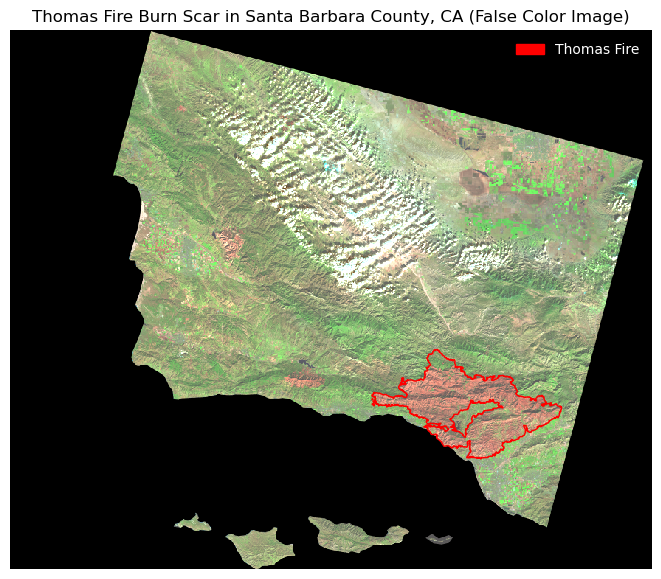

In [23]:

# initializing plot using matplotlib
fig, ax = plt.subplots(figsize=(9, 7)) # setting figure size for output

# plotting false color image (without creating any new variables)
landsat[['swir22', # short-wave
         'nir08', # near-infrared
         # and red variables
         'red']].to_array().plot.imshow(robust=True, 
                    # using robust=True argument to deal with cloud RGB values squishing our plot
                                                           ax=ax)


# plotting Thomas fire perimeter using the selection of our ca fires subselection 
# filtered for fire_name == THOMAS
thomas_fire_border.plot(color="none", # empty fill color so we can clearly see the raster data
                   edgecolor="red", # outline color of red for the Thomas Fire
                   # because we're showing perimeter data
                   ax=ax, # sharing same axes
                   )

# updating labels & legend using mpatches.Patch
thomas_fire_border_patch = mpatches.Patch(color='red', # change color to red
                          label='Thomas Fire') # update label

ax.legend(handles = [thomas_fire_border_patch], 
          frameon=False, # removing legend frame
          loc = "upper right", # setting location to upper right-hand side of the plot
          labelcolor = "white") # changing text color so you can see it on the black background

# removing axes
ax.axis('off')

# updating the title
plt.title("Thomas Fire Burn Scar in Santa Barbara County, CA (False Color Image)") 

# displaying plot
plt.show()